In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

from src.V1_reconst import generate_Y, reconstruct
import seaborn as sns
import time
import os.path

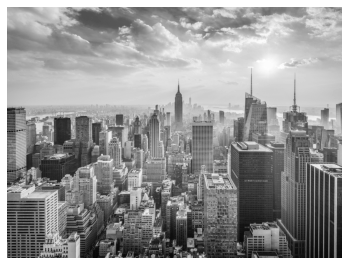

In [4]:
image_nm = 'city.png'
img = Image.open('image/' + image_nm)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)
plt.figure(figsize=(6, 6))
plt.imshow(img, 'gray')
plt.axis('off')
plt.savefig("image/city_grayscaled.png", dpi = 300)
orig_dim = img_arr.shape

(540, 720)
iteration 100
iteration 200
iteration 300
iteration 400


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199765.898050219, tolerance: 160301.18570514838
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85292.7951754428, tolerance: 81621.81762441645
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 879412.6244088578, tolerance: 674449.697004743
  model = cd_fast.enet_coordinate_descent(
/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:

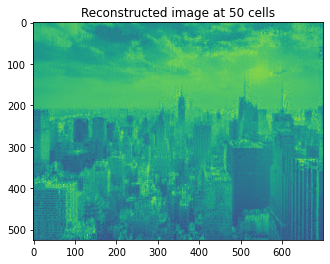

In [7]:
num_cell = 50
cell_size = 7
sparse_freq = 2
alpha = 1

alpha = 1 * 50 / num_cell

rand_weight = False
dim = img_arr.shape
n, m = dim

filter_dim = (30, 30)

filt = np.zeros(filter_dim)
filt_n, filt_m = filter_dim


# for run, num_cell in enumerate([100, 200, 300, 400, 500]):
    # Fix the V1 weights if the random_weight parameter is set to be true
if (rand_weight == True):
    W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

# Preprocess image and add zeros so the cols and rows would fit to the filter for any size
new_n = n + (filt_n - (n % filt_n))
new_m = m + (filt_m - (m % filt_m))

img_arr_aug = np.zeros((new_n, new_m))
img_arr_aug[:n, :m] = img_arr

print(img_arr_aug.shape)
i = 1 # counter
result = np.zeros(img_arr.shape)
cur_n, cur_m = (0, 0)
for pt in range((new_n * new_m) // (filt_n * filt_m)):
    if (i % 100 == 0) :
        print("iteration", i)
    # Randomize V1 weights for each batch if random_weight param is set to false
    if (rand_weight != True) :
        W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

    # keep track over height of the batches
    if (cur_m >= new_m) :
        cur_n += filt_n
        cur_m = 0

    nxt_m = cur_m + filt_m
    pt = img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m]

    y = generate_Y(W, pt)
    W_model = W.reshape(num_cell, filt_n, filt_m)
    theta, reform, s = reconstruct(W_model, y, alpha)

    img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m] = reform
    cur_m = nxt_m

    i+=1

result = img_arr_aug[:n,:m]

# if (run == 0) :
#     # Print original image for comparison
#     plt.imshow(img_arr)
#     plt.title("original")
#     plt.show()

plt.imshow(result)
plt.title("Reconstructed image at {cell} cells".format(cell = num_cell))
plt.show()


In [ ]:
result[result > 255] = 255
result[result < 0] = 0
plt.imshow(result.astype(int))

In [6]:
np.max(result_aug)


NameError: name 'result_aug' is not defined

In [17]:
filt_n, filt_m = (25, 40)

In [122]:
error = np.linalg.norm(img_arr - result, 'fro') / np.sqrt(m*n)

In [123]:
error

6.016559181382442

In [ ]:
help(plt.clim)

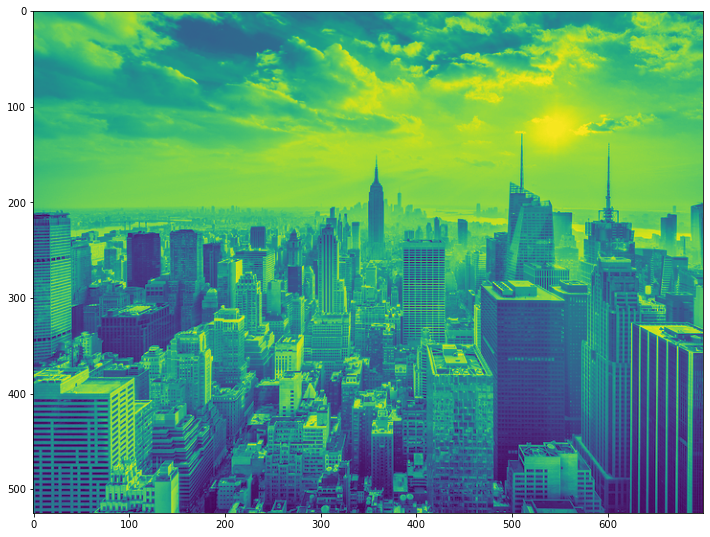

In [106]:
plt.figure(figsize=(12,12))
plt.imshow(img_arr)
plt.clim(0,255)

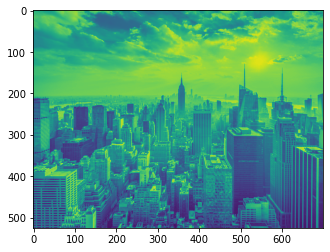

In [117]:
plt.imshow(result)

In [120]:
np.min(np.clip(result, 0, 255))


0.0

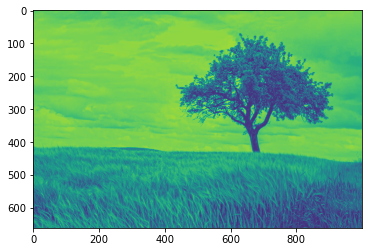

In [143]:
def filter_reconstruction(num_cell, img_arr, cell_size, sparse_freq, filt_dim = (30, 30), alpha = None, rand_weight = False) :
    
    #alpha parameter is dependent on the number of cell if alpha is not specified
    if (alpha == None) :
        alpha = 1 * 50 / num_cell
    
    # Retrieve image dimension
    n, m = img_arr.shape
    
    # Create Filter
    filt = np.zeros(filter_dim)
    filt_n, filt_m = filter_dim
        
    # Fix the V1 weights if the random_weight parameter is set to be true
    if (rand_weight == True):
        W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

    # Preprocess image and add zeros so the cols and rows would fit to the filter for any size
    new_n = n + (filt_n - (n % filt_n))
    new_m = m + (filt_m - (m % filt_m))

    img_arr_aug = np.zeros((new_n, new_m))
    img_arr_aug[:n, :m] = img_arr

    print(img_arr_aug.shape)
    i = 1 # counter
    result = np.zeros(img_arr.shape)
    cur_n, cur_m = (0, 0)
    num_work = (new_n * new_m) // (filt_n * filt_m)
    for pt in range(num_work):
        if (i % (num_work // 5) == 0) :
            print("iteration", i)
        # Randomize V1 weights for each batch if random_weight param is set to false
        if (rand_weight != True) :
            W = V1_weights(num_cell, filter_dim, cell_size, sparse_freq) 

        # keep track over height of the batches
        if (cur_m >= new_m) :
            cur_n += filt_n
            cur_m = 0

        nxt_m = cur_m + filt_m
        pt = img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m]

        y = generate_Y(W, pt)
        W_model = W.reshape(num_cell, filt_n, filt_m)
        theta, reform, s = compress(W_model, y, alpha)

        img_arr_aug[cur_n : (cur_n + filt_n), cur_m : nxt_m] = reform
        cur_m = nxt_m

        i+=1

    result = img_arr_aug[:n,:m]
    return result

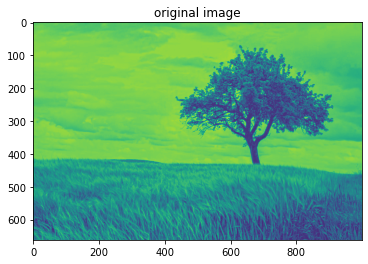

(675, 1005)
iteration 603
iteration 1206
iteration 1809
iteration 2412
iteration 3015


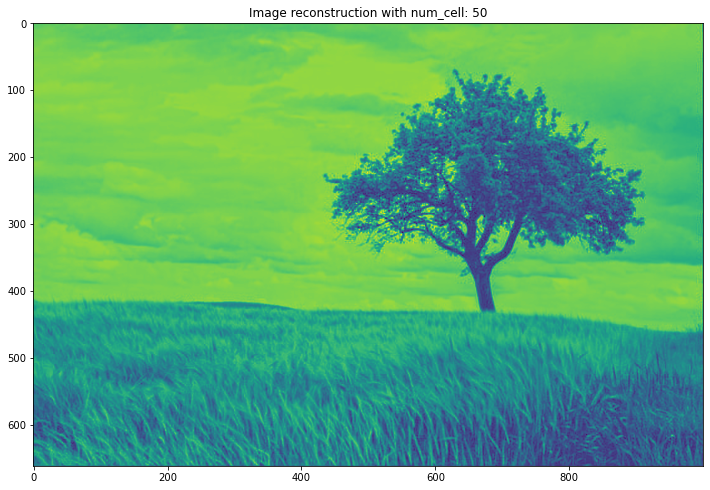

(675, 1005)
iteration 603
iteration 1206
iteration 1809
iteration 2412
iteration 3015


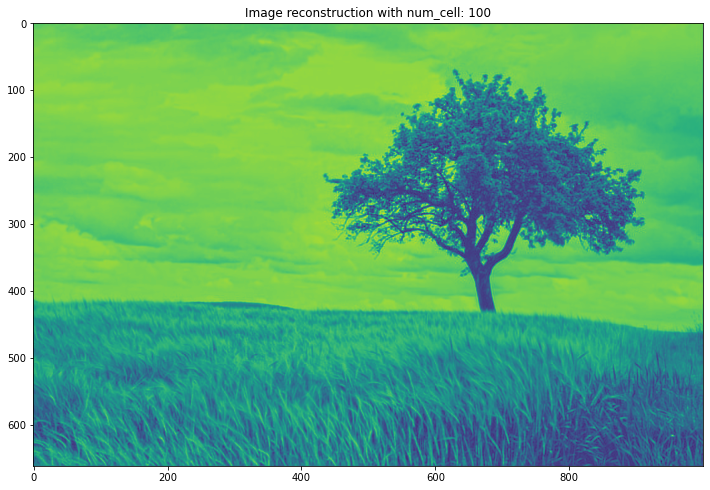

(675, 1005)
iteration 603
iteration 1206
iteration 1809
iteration 2412
iteration 3015


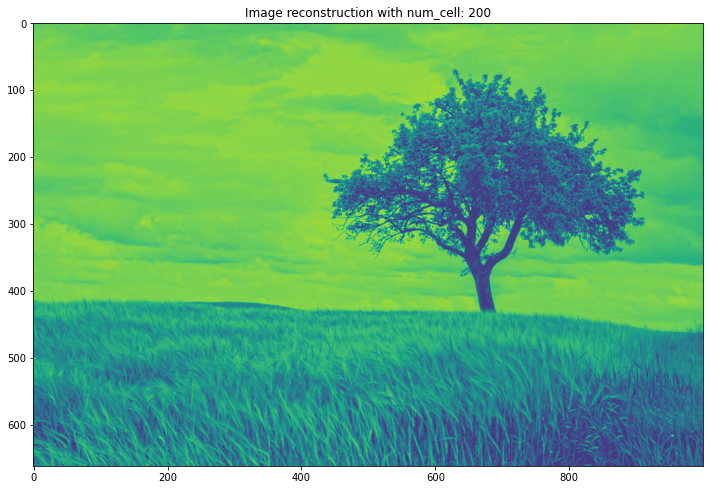

(675, 1005)
iteration 603
iteration 1206
iteration 1809
iteration 2412
iteration 3015


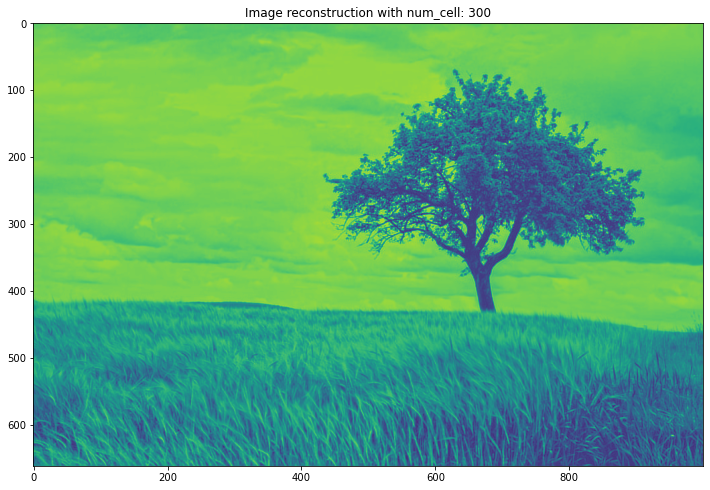

(675, 1005)
iteration 603
iteration 1206
iteration 1809
iteration 2412
iteration 3015


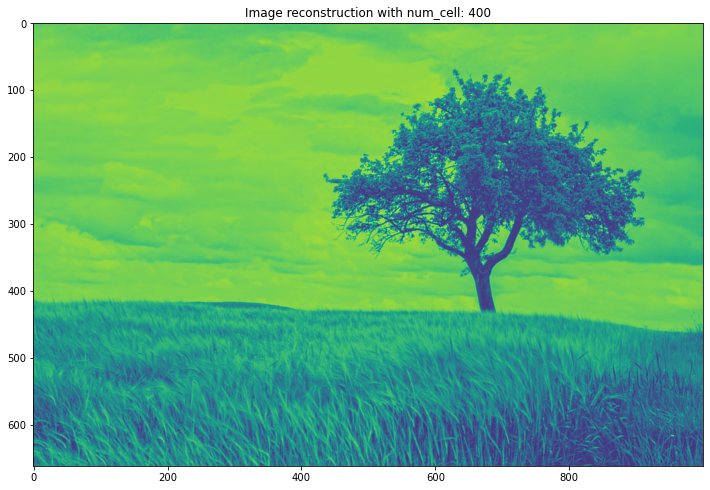

(675, 1005)
iteration 603
iteration 1206
iteration 1809
iteration 2412
iteration 3015


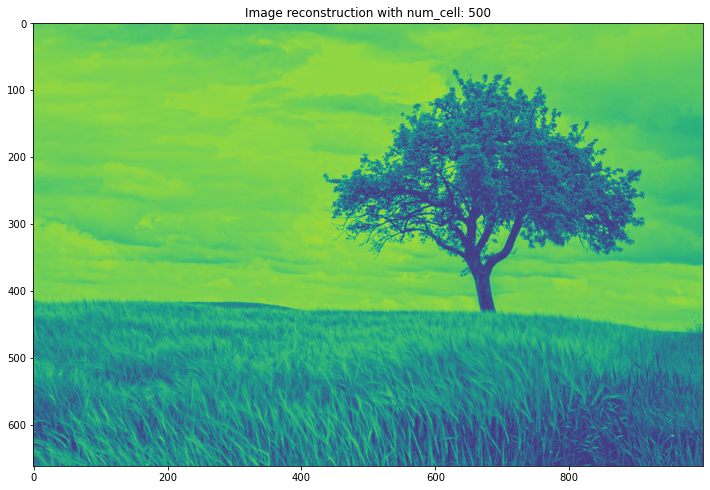

In [144]:
image_nm2 = 'tree.jpg'
img2 = Image.open('image/' + image_nm2)
img2 = ImageOps.grayscale(img2)
img_arr2 = np.asarray(img2)

filt_dim = (20, 20)
num = 100

plt.imshow(img2)
plt.title("original image")
plt.show()

for num_cell in [50, 100, 200, 300, 400, 500]:
    plt.figure(figsize=(12,12))
    plt.imshow(filter_reconstruction(num_cell, img_arr2, 7, 2, filt_dim), vmin=0, vmax=255)
    plt.title("Image reconstruction with num_cell: {num}".format(num = num_cell))
    plt.show()